In [1]:
# =========================================================
# Kaggle: YOLO11 Thermal Object Detection (HIT-UAV)
# - Thermal-aware preprocessing (CLAHE, grayscale->RGB)
# - AdamW optimizer + cosine LR
# - Exports .pt and ONNX for use on another PC
# =========================================================

# ---------------------------------------------------------
# 1. Setup
# ---------------------------------------------------------
!pip -q install --no-input "ultralytics>=8.3.0" # YOLO11-capable versions
!pip -q install --no-input opencv-python matplotlib pyyaml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.5 MB/s eta 0:00:00:00:0100:01


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


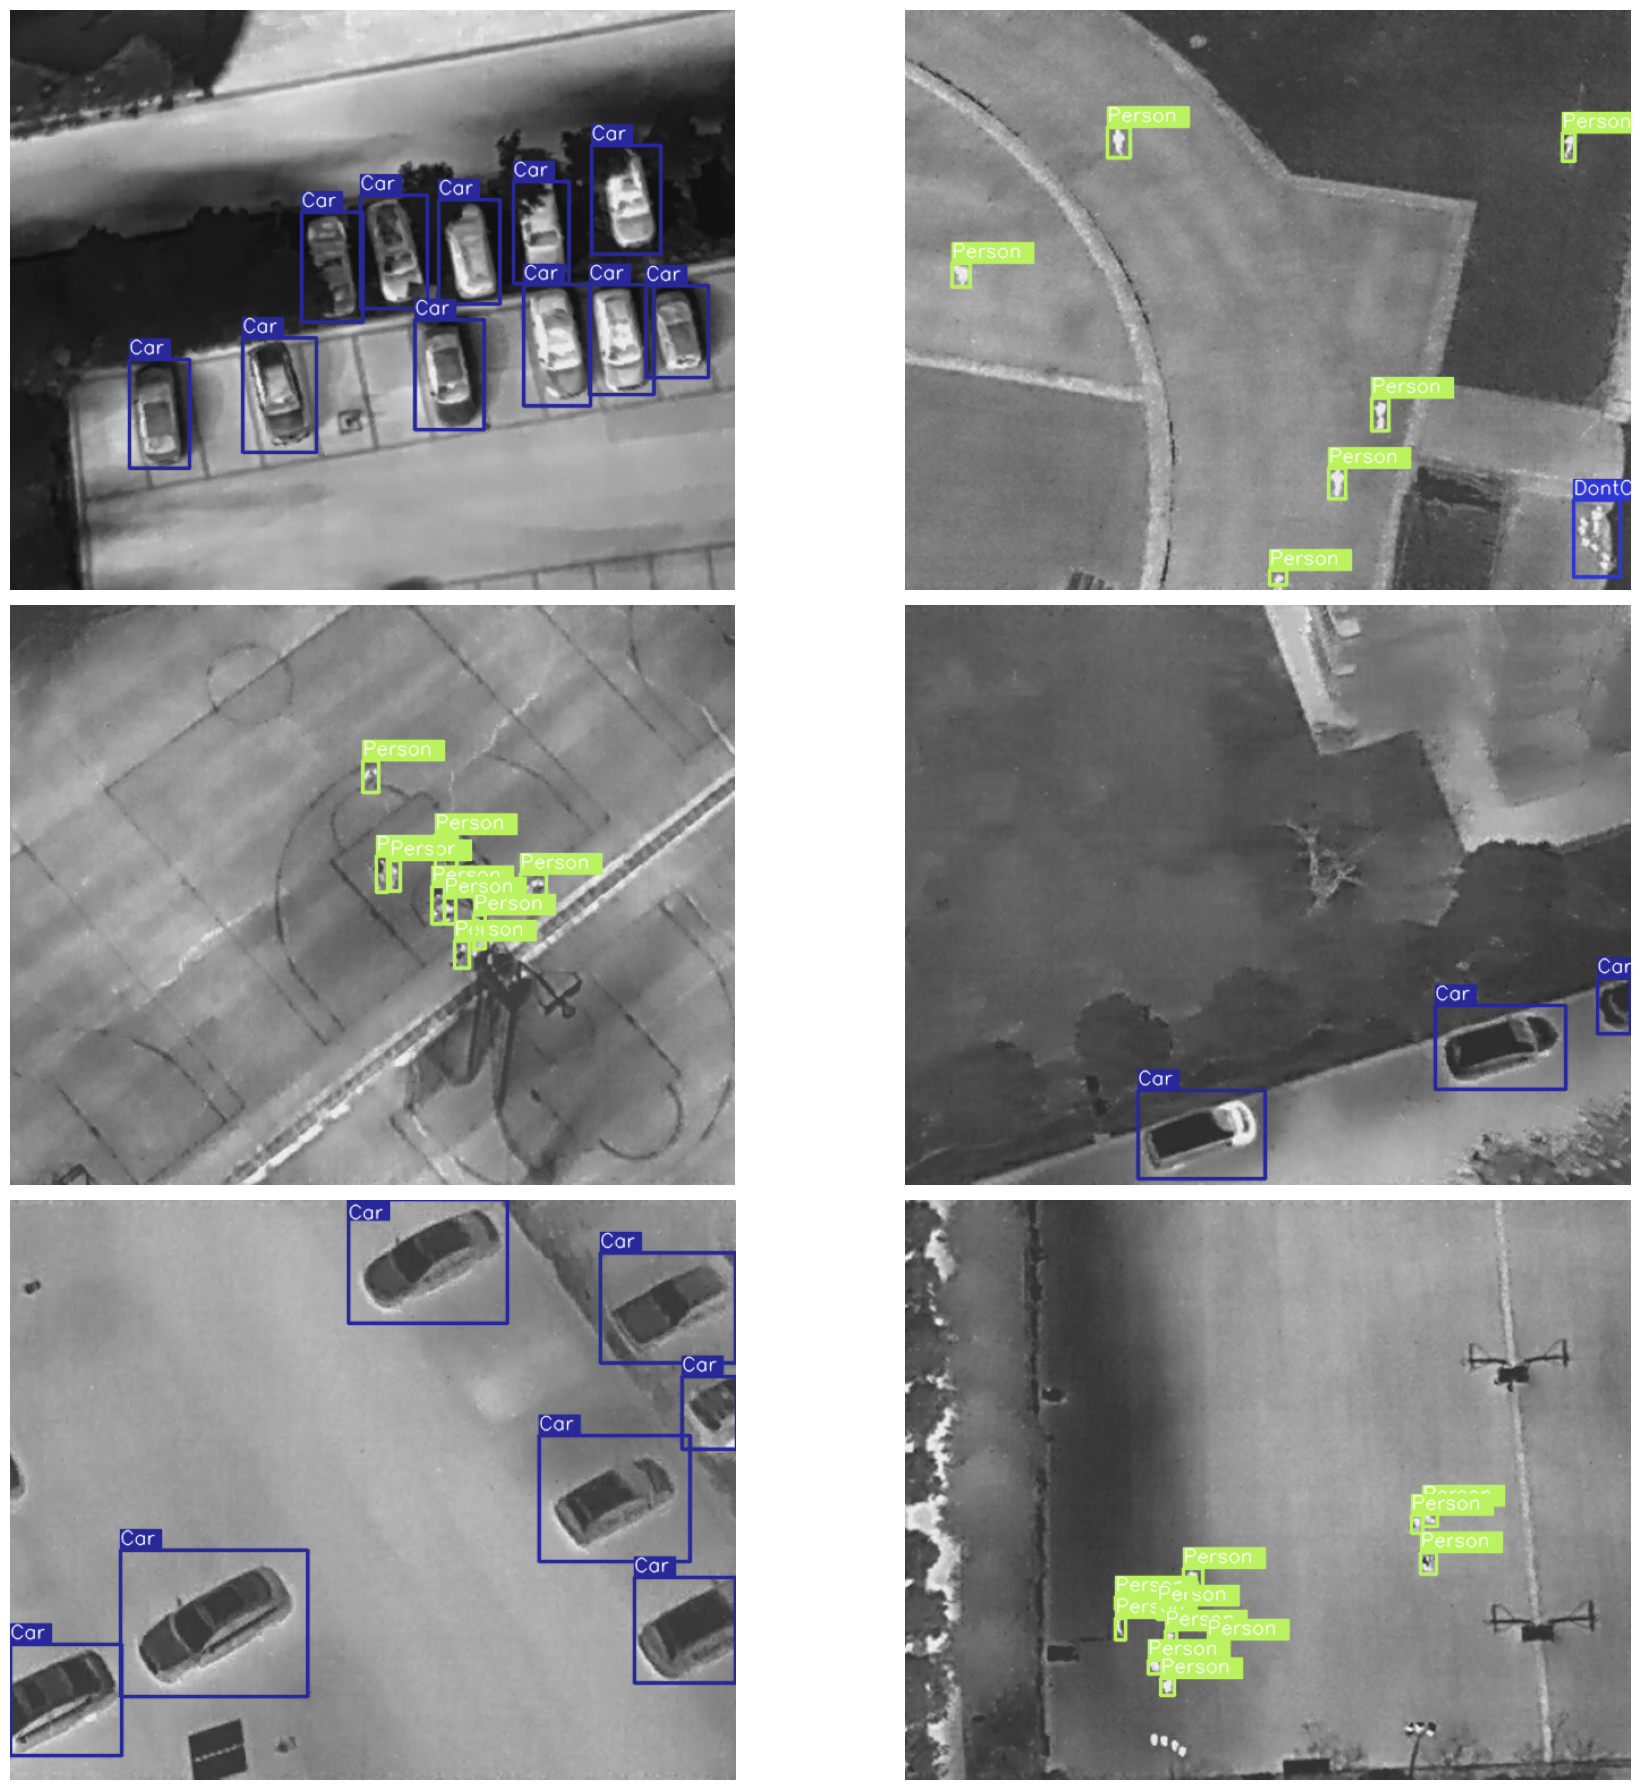

In [2]:

import os, shutil, glob, math, random, yaml, zipfile
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Repro
random.seed(42)
np.random.seed(42)

# Kaggle dataset root (HIT-UAV)
ROOT_DIR = '/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav'
train_imgs_dir = 'images/train'
train_labels_dir = 'labels/train'
val_imgs_dir = 'images/val'
val_labels_dir = 'labels/val'
test_imgs_dir = 'images/test'
test_labels_dir = 'labels/test'

# Classes
classes = ['Person', 'Car', 'Bicycle', 'OtherVehicle', 'DontCare']
colors = np.random.uniform(0, 255, size=(len(classes), 3))

# Make working dirs for preprocessed data
WORK_DIR = '/kaggle/working'
PROC_ROOT = f'{WORK_DIR}/hit-uav-clahe'           # where preprocessed (CLAHE) images will live
for sub in ['images/train','images/val','images/test','labels/train','labels/val','labels/test']:
    Path(f'{PROC_ROOT}/{sub}').mkdir(parents=True, exist_ok=True)

# ---------------------------------------------------------
# 2. Visualization helpers (as provided by you)
# ---------------------------------------------------------
import os, glob, math, random
import cv2
import numpy as np
import matplotlib.pyplot as plt

def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

def plot_box(image, bboxes, labels, classes=classes, colors=colors, pos='above'):
    height, width = image.shape[:2]
    if image.ndim == 2:  # safety for grayscale
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)
    tf = max(lw - 1, 1)
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        xmin, ymin, xmax, ymax = int(x1*width), int(y1*height), int(x2*width), int(y2*height)
        p1, p2 = (xmin, ymin), (xmax, ymax)
        class_name = classes[int(labels[box_num])]
        color = colors[classes.index(class_name)]
        cv2.rectangle(image, p1, p2, color=color, thickness=lw, lineType=cv2.LINE_AA)
        w, h = cv2.getTextSize(class_name, 0, fontScale=lw / 3, thickness=tf)[0]
        outside = p1[1] - h >= 3
        if pos == 'above':
            p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
            cv2.rectangle(image, p1, p2, color=color, thickness=-1, lineType=cv2.LINE_AA)
            cv2.putText(image, class_name, (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
                        cv2.FONT_HERSHEY_SIMPLEX, lw/3.5, (255, 255, 255), tf, lineType=cv2.LINE_AA)
    return image

def plot(image_path, label_path, num_samples=8, classes=classes, colors=colors):
    all_imgs = sorted(glob.glob(image_path+'/*'))
    all_lbls = sorted(glob.glob(label_path+'/*'))
    samples = list(zip(all_imgs, all_lbls))
    random.shuffle(samples)
    samples = samples[:num_samples]
    num_cols = 2
    num_rows = math.ceil(len(samples) / num_cols)
    plt.figure(figsize=(10 * num_cols, 6 * num_rows))
    for i, (img_path, lbl_path) in enumerate(samples):
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if image is None:
            continue
        bboxes, labels = [], []
        with open(lbl_path, 'r') as f:
            for line in f.readlines():
                label, x_c, y_c, w, h = line.strip().split()
                bboxes.append([float(x_c), float(y_c), float(w), float(h)])
                labels.append(int(label))
        result_image = plot_box(image.copy(), bboxes, labels, classes, colors)
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# 3. Visualize raw samples (optional)
# ---------------------------------------------------------
plot(os.path.join(ROOT_DIR, train_imgs_dir), os.path.join(ROOT_DIR, train_labels_dir), num_samples=6)


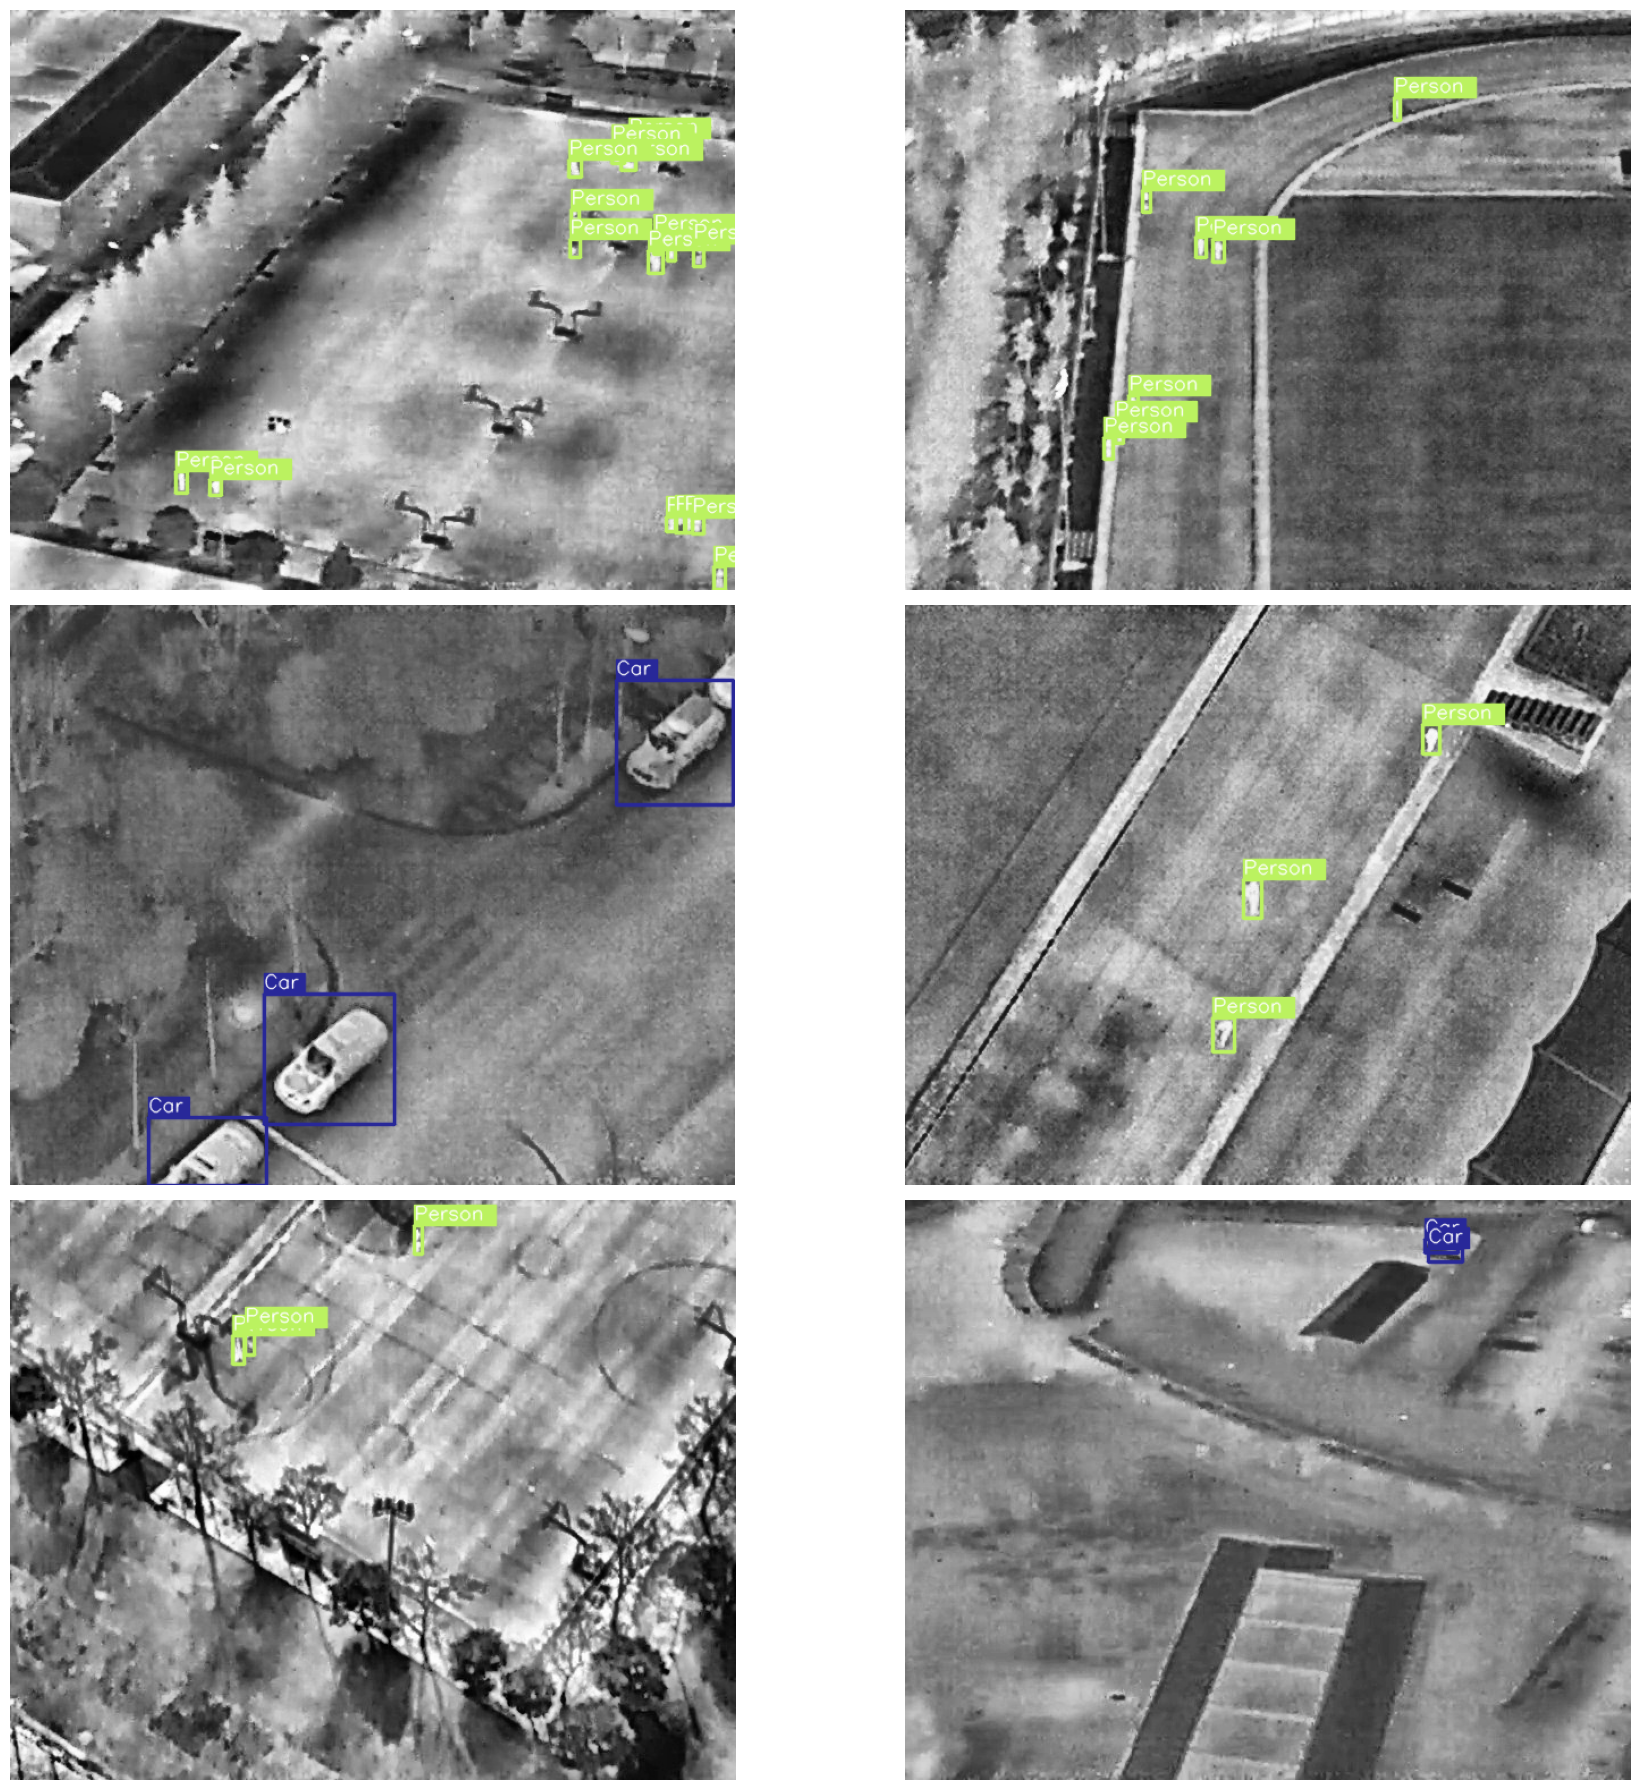

path: /kaggle/working/hit-uav-clahe
train: images/train
val: images/val
test: images/test
nc: 5
names:
  0: Person
  1: Car
  2: Bicycle
  3: OtherVehicle
  4: DontCare

Ultralytics 8.3.214 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.0, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.0, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=0

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        287       2460       0.82      0.662      0.724      0.446
                Person        171       1168      0.843      0.795      0.861      0.445
                   Car        136        719      0.931      0.897       0.96       0.71
               Bicycle         53        554      0.815      0.785       0.86      0.497
          OtherVehicle          9         12      0.512      0.583      0.548      0.458
              DontCare          5          7          1      0.248      0.392      0.121
Speed: 0.2ms preprocess, 4.5ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to /kaggle/working/runs/detect/train
Ultralytics 8.3.214 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1661.8±919.3 MB/s, size: 106.6 KB)
val: Scanning /kaggle/working/hit-uav-clahe/labels/val.cache... 287 images, 0 bac

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        287       2460      0.821      0.661      0.724      0.444
                Person        171       1168      0.845      0.793      0.862      0.444
                   Car        136        719      0.931      0.896       0.96      0.709
               Bicycle         53        554      0.819      0.783      0.858      0.497
          OtherVehicle          9         12      0.512      0.583      0.548       0.46
              DontCare          5          7          1      0.248      0.392      0.109
Speed: 1.3ms preprocess, 9.4ms inference, 0.1ms loss, 2.4ms postprocess per image
Results saved to /kaggle/working/runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ea99ad72dd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']

In [3]:

# ---------------------------------------------------------
# 4. Thermal-aware preprocessing
#    - Load as grayscale (8-bit)
#    - Optional invert to normalize palettes (black-hot -> white-hot)
#    - CLAHE to boost local contrast
#    - Stack to 3 channels so YOLO sees "RGB"-shaped tensors
# ---------------------------------------------------------
def clahe_enhance(img_gray, clip_limit=3.0, tile_grid=(8,8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid)
    return clahe.apply(img_gray)

def normalize_palette_to_white_hot(img_gray, invert_if_needed=True):
    # Heuristic: if mean is low but hot objects are dark (black-hot), inverting often helps.
    # We'll inspect bright vs. dark foreground by comparing top-percentile pixels.
    if not invert_if_needed:
        return img_gray
    p99 = np.percentile(img_gray, 99)
    p1  = np.percentile(img_gray, 1)
    # If the bright tail isn't much brighter than the dark tail, skip. Otherwise,
    # try both and pick the version with higher local contrast.
    orig_contrast = p99 - p1
    inv = 255 - img_gray
    p99i = np.percentile(inv, 99); p1i = np.percentile(inv, 1)
    inv_contrast = p99i - p1i
    return inv if inv_contrast > orig_contrast else img_gray

def ensure_3ch(img_gray):
    return np.stack([img_gray, img_gray, img_gray], axis=-1)

def copy_split(src_img_dir, src_lbl_dir, dst_img_dir, dst_lbl_dir,
               clip_limit=3.0, tile_grid=(8,8), invert_if_needed=True):
    img_paths = sorted(glob.glob(os.path.join(src_img_dir, '*')))
    for ip in img_paths:
        name = os.path.basename(ip)
        stem, ext = os.path.splitext(name)
        # Read grayscale robustly
        img = cv2.imread(ip, cv2.IMREAD_GRAYSCALE)
        if img is None:
            # fallback: read color -> convert
            img_color = cv2.imread(ip, cv2.IMREAD_COLOR)
            if img_color is None:
                print(f"[WARN] Could not read {ip}")
                continue
            img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
        # Normalize palette and enhance
        img = normalize_palette_to_white_hot(img, invert_if_needed=invert_if_needed)
        img = clahe_enhance(img, clip_limit=clip_limit, tile_grid=tile_grid)
        img3 = ensure_3ch(img)
        out_path = os.path.join(dst_img_dir, f'{stem}.jpg')  # store as jpg
        cv2.imwrite(out_path, img3, [int(cv2.IMWRITE_JPEG_QUALITY), 95])

        # Copy label (same basename, .txt)
        lbl_src = os.path.join(src_lbl_dir, f'{stem}.txt')
        lbl_dst = os.path.join(dst_lbl_dir, f'{stem}.txt')
        if os.path.exists(lbl_src):
            shutil.copy(lbl_src, lbl_dst)

# Run preprocessing for train/val/test
copy_split(os.path.join(ROOT_DIR, train_imgs_dir),
           os.path.join(ROOT_DIR, train_labels_dir),
           os.path.join(PROC_ROOT, 'images/train'),
           os.path.join(PROC_ROOT, 'labels/train'),
           clip_limit=3.0, tile_grid=(8,8), invert_if_needed=True)

copy_split(os.path.join(ROOT_DIR, val_imgs_dir),
           os.path.join(ROOT_DIR, val_labels_dir),
           os.path.join(PROC_ROOT, 'images/val'),
           os.path.join(PROC_ROOT, 'labels/val'),
           clip_limit=3.0, tile_grid=(8,8), invert_if_needed=True)

copy_split(os.path.join(ROOT_DIR, test_imgs_dir),
           os.path.join(ROOT_DIR, test_labels_dir),
           os.path.join(PROC_ROOT, 'images/test'),
           os.path.join(PROC_ROOT, 'labels/test'),
           clip_limit=3.0, tile_grid=(8,8), invert_if_needed=True)

# Quick peek at preprocessed
plot(os.path.join(PROC_ROOT, 'images/train'), os.path.join(PROC_ROOT, 'labels/train'), num_samples=6)

# ---------------------------------------------------------
# 5. Create dataset.yaml (point to preprocessed data)
#    NOTE: keep 5 classes including DontCare. To ignore DontCare, remove it here.
# ---------------------------------------------------------
dataset_yaml_path = f"{WORK_DIR}/dataset.yaml"
dataset_yaml = f"""path: {PROC_ROOT}
train: images/train
val: images/val
test: images/test
nc: 5
names:
  0: Person
  1: Car
  2: Bicycle
  3: OtherVehicle
  4: DontCare
"""
with open(dataset_yaml_path, "w") as f:
    f.write(dataset_yaml)
print(open(dataset_yaml_path).read())

# ---------------------------------------------------------
# 6. Train YOLO11 (thermal-friendly augs + AdamW + cosine LR)
#    - Disable HSV augment (not useful for grayscale)
#    - Keep flips and mild geometric augs
#    - Use rect training for 640x512 aspect
# ---------------------------------------------------------
MODEL = "yolo11s.pt"  # good starting backbone. Try yolo11m.pt if VRAM allows.

model = YOLO(MODEL)

results = model.train(
    data=dataset_yaml_path,
    epochs=200,
    imgsz=640,             # YOLO friendly; will letterbox from 640x512
    batch=-1,              # auto batch for available VRAM
    device=0,              # Kaggle GPU
    pretrained=True,
    rect=True,             # rectangular training keeps aspect ratio buckets
    # Optimizer / LR schedule
    optimizer="AdamW",
    lr0=1e-3,              # Adam/AdamW recommended start
    lrf=0.01,              # final LR multiplier
    cos_lr=True,           # cosine decay
    warmup_epochs=3,
    weight_decay=0.0005,
    # Thermal-friendly augment
    hsv_h=0.0, hsv_s=0.0, hsv_v=0.0,  # disable HSV
    flipud=0.0, fliplr=0.5,
    mosaic=0.5, mixup=0.0,
    degrees=0.0, translate=0.1, scale=0.9, shear=0.0,
    erasing=0.0,
    # Loss (slightly higher box weight can help small objects)
    box=7.5, cls=0.5, dfl=1.0,
    patience=50,
    save=True,
    val=True
)

# ---------------------------------------------------------
# 7. Validate & Predict examples
# ---------------------------------------------------------
metrics = model.val()
print(metrics)

# Predict on a handful of validation images
pred_dir = f"{WORK_DIR}/sample_preds"
Path(pred_dir).mkdir(parents=True, exist_ok=True)
pred = model.predict(source=os.path.join(PROC_ROOT, 'images/val'), save=True, save_txt=True, project=pred_dir, name='preds', conf=0.25, iou=0.6, max_det=300)


In [4]:

# ---------------------------------------------------------
# 8. Locate weights and export for other PCs
# ---------------------------------------------------------
# Find best.pt from the last training run
best_paths = glob.glob('runs/detect/*/weights/best.pt')
best_paths.sort(key=os.path.getmtime)
best_pt = best_paths[-1] if best_paths else None
print("BEST PT:", best_pt)

# Export ONNX (portable) and TorchScript
if best_pt:
    exp_model = YOLO(best_pt)
    onnx_path = exp_model.export(format="onnx", opset=12, dynamic=True, simplify=True)
    ts_path   = exp_model.export(format="torchscript")
    print("Exported:", onnx_path, ts_path)

# ---------------------------------------------------------
# 9. Zip artifacts for download (Kaggle -> other PC)
# ---------------------------------------------------------
def zip_dir(path, zip_name):
    with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zf:
        for root, _, files in os.walk(path):
            for f in files:
                p = os.path.join(root, f)
                zf.write(p, os.path.relpath(p, path))

artifacts = {
    "weights_zip": f"{WORK_DIR}/yolo11_hit-uav_weights.zip",
    "preds_zip":   f"{WORK_DIR}/yolo11_hit-uav_preds.zip",
}

# Zip weights folder (contains best.pt, last.pt)
weights_dir = Path(best_pt).parent if best_pt else None
if weights_dir:
    zip_dir(str(weights_dir), artifacts["weights_zip"])
    print("Zipped weights ->", artifacts["weights_zip"])

# Zip prediction images
pred_folder = f"{pred_dir}/preds"
if os.path.exists(pred_folder):
    zip_dir(pred_folder, artifacts["preds_zip"])
    print("Zipped preds ->", artifacts["preds_zip"])

print("\nAll done. Download from the right-hand 'Output' panel:")
print("- best.pt inside yolo11_hit-uav_weights.zip")
print("- model.onnx (in the export dir created by Ultralytics)")
print("- sample predictions in yolo11_hit-uav_preds.zip")

# ---------------------------------------------------------
# 10. (Optional) How to run on another PC (notes)
#   pip install ultralytics
#   from ultralytics import YOLO
#   model = YOLO('best.pt')  # or YOLO('model.onnx')
#   model.predict(source='path/to/images', save=True)
# ---------------------------------------------------------


BEST PT: runs/detect/train/weights/best.pt
Ultralytics 8.3.214 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLO11s summary (fused): 100 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 9, 8400) (18.3 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 4.0s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.18.0 opset 12...
ONNX: slimming with onnxslim 0.1.71...
ONNX: export success ✅ 13.0s, saved as 'runs/detect/train/weights/best.onnx' (36.6 MB)

Export complete (13.8s)
Results saved to /kaggle/working/runs/detect/train/weights